<a href="https://colab.research.google.com/github/DGkurnia/discuss1/blob/main/bmlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Tahap Awal**
# Nama : Derfansyah Guswiranata Kurnia
# email : weerakurnia@gmail.com
# Identitas dicoding : dgkurnia
# Domisili : Jakarta Timur

In [ ]:
#Initiasi perpustakaan dasar
import numpy as np
from google.colab import files

#perpustakaan untuk inspeksi
"""
#Inspeksi tensorflow dan optimasi (penginstalan Tensorflow terbaru)
#!pip uninstall tensorflow -y #uninstall tensorflow
#Instal ulang versi 2.17
#!pip install tensorflow==2.17.0
"""

#Bagian matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


#Lanjutan impor perpustakaan
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import mean_squared_error as mse

#eksekusi file
from google.colab import drive
drive.mount('/content/gdrive')
import zipfile,os
#lanjutan perpustakaan
import time

#Inspeksi tensorflow
!pip install tensorflow==2.15
!pip install tensorflow-gpu==2.15
!pip install keras==2.15
!pip install keras-gpu==2.15
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from keras.callbacks import EarlyStopping as es



In [2]:
#inspeksi
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs available: {gpus}")
else:
    print("No GPU available.")

GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


** Fasa upload berkas**

In [9]:
#Persiapan filr dari github untuk ekstraksi
!wget -O janken.zip https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip
!ls
#ekstraksi File
!unzip janken.zip

In [3]:
# Inisiasi proyek
kertascol = '/content/rockpaperscissors/paper'
batucol = '/content/rockpaperscissors/rock'
guntingcol = '/content/rockpaperscissors/scissors'
colasli = '/content/rockpaperscissors/rps-cv-images'

#deklarasi variable os deklarasi daftar
listdirkert = os.listdir(kertascol) #kertas
listdirbatu = os.listdir(batucol) #batu
listdirgunting = os.listdir(guntingcol) #gunting
listdirvalid = os.listdir(colasli) #validasi gambar

# persiapan data
print("total data gunting", len(listdirkert))
print("total data kertas", len(listdirbatu))
print("total data batu", len(listdirgunting))
print("total data validasi", len(listdirvalid))

total data gunting 712
total data kertas 726
total data batu 750
total data validasi 4


**Eksekusi Awal**

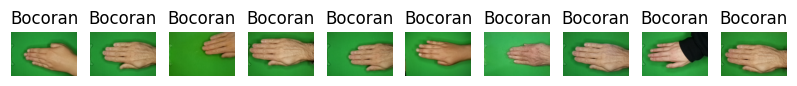

In [4]:
#Identifikasi gambar tahap awal
baris = 10
kolom = 10

#pembuatan file file gambar kertas untuk lima jenis file gambar berbeda
filegmb = [a for a in listdirkert if a.endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
#intip 10 gambar pertama (ilustrasi grafik)
plt.figure(figsize=(10, 10))
#iterasi 10 gambar pertama (variable bocoran)
bocoran = enumerate(filegmb[:10])
#iterasi sesunguhnya
for a, filegmb in bocoran :
  jlrgmb = os.path.join(kertascol, filegmb)
  gmb = mpimg.imread(jlrgmb) #Untuk inspeksi gambar
  #Bagian sub grafik
  plt.subplot(baris, kolom, a+1)
  plt.imshow(gmb)
  plt.title('Bocoran')
  plt.axis('off')#mema
  #penampilan bocoran
plt.show()

**persiapan data latihan & data validasi**

In [5]:
#Tahap awal melalui Image Data Generator (IDG) bagian impor perpustakaan
import tensorflow as tf #Bagian tensor flow
from tensorflow.keras.preprocessing.image import ImageDataGenerator as idg
from tensorflow.keras.optimizers import RMSprop as rmsp
#Eksekusi ImageDataGenerator
img_latihan = idg(
    rescale=1./255, rotation_range=20,
    horizontal_flip=True, vertical_flip=True,
    width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2,
    fill_mode='nearest',
    validation_split=0.4 #Nilai validasi adalah 40 persen
)

#konstruksi data latihan dan validasi (latihan)
seksi_latihan = img_latihan.flow_from_directory(
    colasli,
    target_size=(150, 150), #ukuran 150*150
    batch_size=64,
    class_mode='categorical',
    subset='training'
)
#data validasi
seksi_validasi = img_latihan.flow_from_directory(
    colasli,
    target_size=(150, 150),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

#lanjut ke tahap selanjutmya

Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


**Fasa dua**

In [39]:
#validasi
from tensorflow.keras import layers, models
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
#Penetapan ukuran
lbr_gmb = 150
tgi_gmb = 150 #Lebar dan tinggi
#persiapan model keras
tf.keras.models.Sequential([
    # Lapisan 32
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='valid',
    input_shape=(lbr_gmb, tgi_gmb, 3)), tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    # Lapisan 64
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='valid'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    # Lapisan 128
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='valid'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    # Lapisan 256
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='valid'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    # Lapisan 512
    tf.keras.layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='valid'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),

    # Flatten the output before feeding into dense layers
    tf.keras.layers.Flatten(),

    # Dropout for regularization
    tf.keras.layers.Dropout(0.5),

    # Fully connected layer with ReLU activation
    tf.keras.layers.Dense(512, activation='relu'),

    # Output layer for classification (assuming three classes)
    tf.keras.layers.Dense(3, activation='softmax')
])


**Bagian tiga**
##Kompilasi dan Penyesuaian
###Komposisi
- a. persiapan laju pembelajaran
- b. penyesuaian

In [40]:
#Persiapan laju penyesuaian (Deklarasi laju)
jadwal = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=7500, decay_rate=0.950,
    staircase=True
)
#Deklarasi optimasi
jadopti = tf.keras.optimizers.Adam(learning_rate=jadwal) #Jadwal optimasi
#Pemanggilan kembali tensor
pangiltensor = tf.keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=1)
escallback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 8, restore_best_weights=True) #kesabaran inspeksi
mccallback = tf.keras.callbacks.ModelCheckpoint(filepath='model_best.keras', monitor='val_accuracy', save_best_only=True) #model checkpoint callback

In [41]:
#Perpustakaan
from keras.losses import CategoricalFocalCrossentropy as catfoscent
from keras.metrics import Precision, Recall
# Eksekusi Kompilasi dan penyesuaian (kompilasi)
kerasmod.compile(
    loss= catfoscent(alpha=0.25, gamma=2.0),
    optimizer=jadopti, metrics=['accuracy',Precision(), Recall()],
    run_eagerly=True
)

In [ ]:
#Kelas 'Dataset Kustom'
class CustomDataset(tf.data.Dataset):
    def __init__(self, data, labels, batch_size=25):
        super().__init__()
        self.dataset = tf.data.Dataset.from_tensor_slices((data, labels))
        self.batch_size = batch_size

    def preprocess(self):
        return self.dataset.map(self._preprocess_function).shuffle(buffer_size=1000).batch(self.batch_size)

    def _preprocess_function(self, image, label):
        image = tf.image.resize(image, [256, 256]) / 255.0
        return image, label

#Bagian Penyesuaian Epoch
EPOK = 25
batch = len(seksi_latihan) #Langkah menjadi Dinamis
#Pembuatan almanak gambar
almanak = kerasmod.fit(
    seksi_latihan, #Hal ini mewakili seksi latihan
    steps_per_epoch=15,
    epochs= EPOK,
    batch_size= batch,
    validation_data= seksi_validasi,
    validation_steps= 5,
    callbacks=[pangiltensor, escallback, mccallback],
    verbose= 4
)
#hasil di bawah


Epoch 1/25
Epoch 2/25
Epoch 3/25
Epoch 4/25
Epoch 5/25
Epoch 6/25
Epoch 7/25
Epoch 8/25
Epoch 9/25
Epoch 10/25
Epoch 11/25
Epoch 12/25
Epoch 13/25
Epoch 14/25
Epoch 15/25
Epoch 16/25
Epoch 17/25
Epoch 18/25
Epoch 19/25
Epoch 20/25
Epoch 21/25
Epoch 22/25
Epoch 23/25
Epoch 24/25


**Bagian empat: Cek akurasi**

In [43]:
#Bagian 1: Eksodus evaluasi dengan kondisional di sejarah almanak
import numpy as np #Pembulatan <)
if 'val_loss' in almanak.history:  # Inspeksi nilai hilang selama inspeksi
    # Evaluasi model almanak di latohan dan validasi
    akurasi = np.round(kerasmod.evaluate(seksi_latihan),3)  # Hasil Akurasi
    hilang = np.round(kerasmod.evaluate(seksi_validasi),3)  # Hasil hilang
    # Mencetak hasil
    print("Total hilang:", hilang, "Total akurasi:", akurasi)
else:
    print("Tak perlu validasi :)")
#Hasil di sini

14/14 [==============================] - 7s 521ms/step - loss: 0.9143 - accuracy: 0.7712 - precision_1: 0.7712 - recall_1: 0.7712
Total hilang: [0.914 0.771 0.771 0.771] Total akurasi: [0.921 0.767 0.767 0.767]


**Inspeksi Visual Hasil Epok via Matplotlib**

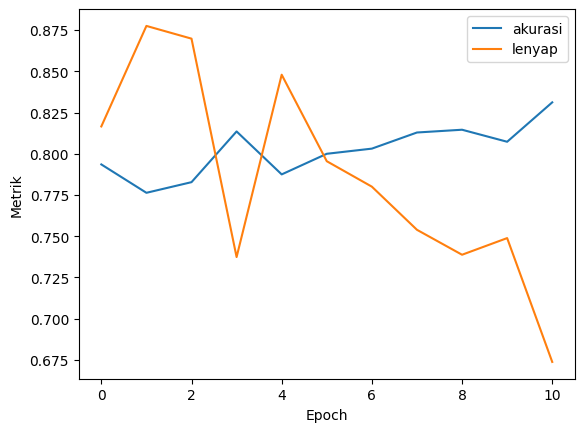

In [44]:
#Bagian impor sudah dilakukan
#Eksekusi hasil di grafik yg berada di bawah
plt.plot(almanak.history['accuracy'], label='akurasi')
plt.plot(almanak.history['loss'], label='lenyap')
plt.xlabel('Epoch')
plt.ylabel('Metrik')
plt.legend()
plt.show()

In [45]:
#Penyimpanan model
kerasmod.save('danxhmodelv1,3.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Bagian 5: Proses sebenarnya

In [ ]:
#Bagian awal
mdjadi = tf.keras.models.load_model('danxhmodelv1,3.h5') #Hasil inspeksi model jasi
#print(mdjadi) pemeriksaan model

#Bagian eksekusi fungsi jadi
def predict_this (mdjadi) :
  hup = files.upload() #Hasil upload
  #print(hup) #Inspeksi hasil
  for fn in hup.keys():
    #A. Jalur unduhan file
    junduh = fn #persiapan
    gmbjadi = image.load_img(junduh, target_size=(lbr_gmb, tgi_gmb)) #memasukan gambar
    #print(gmbjadi) #Inspeksi gambar
    gmb_aray = image.img_to_array(gmbjadi) #konversi gambar
    #print(gmb_aray) #Inspeksi gambar dalam array
    gmb_aray = np.expand_dims(gmb_aray, axis=0) / 255.0 #pengisian array untuk hasil

    #Komposisi prediksi
    prediksi = mdjadi.predict(gmb_aray)
    #print(prediksi)
    nama_kelas = ['Rock', 'Paper', 'Scissors']
    #deklarasi argumen maksimal
    maxarg = np.argmax(prediksi)
    prediksi_kelas = nama_kelas[maxarg]
    #print(prediksi_kelas)

    #Bagian penampilan gambar dan prediksi
    plt.show(gmbjadi) #ilustrasi gambar jadi
    plt.title(f"Prediksi: {prediksi_kelas}")
    plt.axis('off')
    plt.show()
    #Bagian pengunduhan gambar
predict_this(mdjadi)